# Test beam analysis

### Necessary Imports

In [1]:
import os
import uproot
import math
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import curve_fit
from scipy.stats import norm, moyal
from scipy.signal import find_peaks

pd.options.display.max_columns = 500
pd.options.display.max_rows = 100000

### Read the nTuple data into a Pandas DataFrame

In [2]:
# Define the custom order for the keys
custom_order = [
    'ACT0L', 'ACT0R', 'ACT1L', 'ACT1R', 'ACT3L', 'ACT3R',
    'TOF00', 'TOF01', 'TOF02', 'TOF03', 'TOF10', 'TOF11', 'TOF12', 'TOF13',
    'TriggerScint',
    'PbGlass',
    'HD0', 'HD1', 'HD2', 'HD3', 'HD4', 'HD5', 'HD6', 'HD7', 'HD8', 'HD9', 'HD10', 'HD11', 'HD12', 'HD13', 'HD14'
]

ntuple_dir = "/Users/jrenner/local/data/beamtest/ntuple_files/"
ntuple_pd_dir = "/Users/jrenner/temp/hk/beamtest/ntuple_dataframes/"
    
def ntuple_to_pd(filename):
    
    # Open the TTree anaTree and get all keys
    events = uproot.open("{}:anaTree".format(filename))
    main_keys = events.keys()
    
    # Construct the analysis dataframe
    df = pd.DataFrame()
    for key in main_keys:
        
        # Skip the nChannels key
        if(key == 'nChannels'):
            continue

        arr = events[key].array(library='np').squeeze()

        # Convert the array to a DataFrame
        df_key = pd.DataFrame(arr)

        # Rename the columns to include the key name
        df_key.columns = [f"{key}{i}" for i in df_key.columns]

        # Concatenate the new DataFrame to the existing one
        df = pd.concat([df, df_key], axis=1)
        
    return df

def ntuple_to_pd_multipeak(filename):
    
    # Open the TTree anaTree and get all keys
    events = uproot.open("{}".format(filename))
    main_keys = events.keys()
    
    # Construct the analysis dataframes for each detector element.
    df_dict = {}
    for key in main_keys:
        
        key_noversion = key.split(';')[0]
        
        # Skip the EventInfo key
        if(key_noversion == 'EventInfo'):
            continue
        
        print("Processing dataframe for",key,"...")
        
        # Get the number of peaks and timestamps
        nPeaks        = events[key]['nPeaks'].array()
        timeStamp     = events[key]['timeStamp'].array()
        triggerTime   = events[key]['triggerTime'].array()
        Pedestal      = events[key]['Pedestal'].array()
        PedestalSigma = events[key]['PedestalSigma'].array()
        PeakVoltage   = events[key]['PeakVoltage'].array()
        PeakTime      = events[key]['PeakTime'].array()
        SignalTime    = events[key]['SignalTime'].array()
        IntCharge     = events[key]['IntCharge'].array()
        
        # Iterate through the array elements and save information for each peak.
        l_evt, l_ipk, l_nPeaks, l_timeStamp, l_triggerTime = [], [], [], [], []
        l_Pedestal, l_PedestalSigma = [], []
        l_PeakVoltage, l_PeakTime, l_SignalTime, l_IntCharge = [], [], [], []
        for evt, (npk, tstamp, ttime, pedestal, spedestal, pkv, pkt, sigt, chg) in enumerate(zip(nPeaks,timeStamp,triggerTime,Pedestal,PedestalSigma,PeakVoltage,PeakTime,SignalTime,IntCharge)):
            
            # Update the lists for each peak.
            if(npk == 0):
                l_evt.append(evt)
                l_ipk.append(-1)
                l_nPeaks.append(npk)
                l_timeStamp.append(tstamp)
                l_triggerTime.append(ttime)
                l_Pedestal.append(pedestal)
                l_PedestalSigma.append(spedestal)
                l_PeakVoltage.append(-1)
                l_PeakTime.append(-1)
                l_SignalTime.append(-1)
                l_IntCharge.append(-1)
            else:
                for ipk in range(npk):
                    l_evt.append(evt)
                    l_ipk.append(ipk)
                    l_nPeaks.append(npk)
                    l_timeStamp.append(tstamp)
                    l_triggerTime.append(ttime)
                    l_Pedestal.append(pedestal)
                    l_PedestalSigma.append(spedestal)
                    l_PeakVoltage.append(pkv[ipk])
                    l_PeakTime.append(pkt[ipk])
                    l_SignalTime.append(sigt[ipk])
                    l_IntCharge.append(chg[ipk])
        
        # Create a new dataframe.
        df = pd.DataFrame({'event':  l_evt,
                           'iPeak': l_ipk,
                           'nPeaks': l_nPeaks,
                           'timeStamp': l_timeStamp,
                           'triggerTime': l_triggerTime,
                           'Pedestal': l_Pedestal,
                           'PedestalSigma': l_PedestalSigma,
                           'PeakVoltage': l_PeakVoltage,
                           'PeakTime': l_PeakTime,
                           'SignalTime': l_SignalTime,
                           'IntCharge': l_IntCharge
                          })

        # Set this as the dataframe or concatenate it to the one that is already there.
        if(key_noversion in df_dict):
            last_evt = df_dict[key_noversion]['event'].values[-1]+1
            df['event'] = df['event'] + last_evt
            print("Concatenating to",key_noversion,"starting with event number",last_evt)
            df_dict[key_noversion] = pd.concat([df_dict[key_noversion], df], ignore_index=True)
        else:
            df_dict[key_noversion] = df
            
    # Add EventInfo information.
    df = pd.DataFrame( {'RunNumber':   events['EventInfo']['RunNumber'].array(library='np'),
                        'EventNumber': events['EventInfo']['EventNumber'].array(library='np'),
                        'SpillNumber': events['EventInfo']['SpillNumber'].array(library='np')})
    df_dict['EventInfo'] = df
        
    return df_dict

def plot_histograms_for_each_signal(df_dict, base_dir=".", rnum = 0, quantity='nPeaks', select_nonzero_peaks=False, logscale=False):
    
    out_dir = f"{base_dir}/{rnum}"
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
        
    print("Plotting all histograms for",quantity,"for all signals in run",rnum)

    # Create a grid of 8 rows x 4 columns
    fig, axes = plt.subplots(8, 4, figsize=(16, 24))
    flat_axes = axes.ravel()
    
    fig.suptitle(f'Run {rnum}', fontsize=24, y=1.02)

    # Iterate based on the custom order
    for key, ax in zip(custom_order, flat_axes):
        df = df_dict[key]
        
        # Select only non-zero peaks if specified.
        if(select_nonzero_peaks):
            df_select = df[df['nPeaks'] > 0]
        else:
            df_select = df

        # Plot histogram for the current signal on its corresponding axis
        n, bins, patches = ax.hist(df_select[quantity], bins=20, edgecolor='black', alpha=0.7, label=key)  # capture output to use in legend
        #ax.set_title(key)
        ax.set_xlabel(quantity)
        ax.set_ylabel('Counts/bin')
        ax.legend()  # Add legend
        
        if(logscale):
            ax.set_yscale('log')

    # Adjust the layout so the plots do not overlap
    plt.tight_layout()
    #plt.show()
    plt.savefig(f"{out_dir}/{quantity}.pdf", bbox_inches='tight')

def read_dataframes_from_csv(directory):
    file_names = os.listdir(directory)
    dfs = {}
    for file in file_names:
        if file.endswith('.csv'):
            key = file.split('.csv')[0]
            dfs[key] = pd.read_csv(os.path.join(directory, file))
    return dfs

def compute_statistics(df):
    
    # Compute average statistics
    avg_nPeaks = df['nPeaks'].mean()
    avg_Pedestal = df['Pedestal'].mean()
    avg_PedestalSigma = df['PedestalSigma'].mean()
    
    # For histograms, bin the data and find the bin with the most counts
    def get_hist_peak(data, bins=100):
        hist, bin_edges = np.histogram(data, bins=bins)
        peak_bin = np.argmax(hist)
        peak_value = (bin_edges[peak_bin] + bin_edges[peak_bin + 1]) / 2
        return peak_value

    peak_PeakVoltage = get_hist_peak(df[df['PeakVoltage'] > 0.2]['PeakVoltage'])
    peak_PeakTime = get_hist_peak(df[df['PeakTime'] > 10]['PeakTime'])
    peak_SignalTime = get_hist_peak(df[df['SignalTime'] > 0.2]['SignalTime'])
    peak_IntCharge = get_hist_peak(df[df['IntCharge'] > 0.025]['IntCharge'])
    
    stats = {
        'avg_nPeaks': avg_nPeaks,
        'avg_Pedestal': avg_Pedestal,
        'avg_PedestalSigma': avg_PedestalSigma,
        'peak_PeakVoltage': peak_PeakVoltage,
        'peak_PeakTime': peak_PeakTime,
        'peak_SignalTime': peak_SignalTime,
        'peak_IntCharge': peak_IntCharge
    }
    
    return stats

def plot_statistics_vs_run(statistics_data, statistic_keys, signal_set, base_dir, signal_set_name):
    
    out_dir = f"{base_dir}/summary"
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
        
    n_statistics = len(statistic_keys)
    
    # Define number of rows and columns for the subplots.
    n_cols = 1
    n_rows = math.ceil(n_statistics / n_cols)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
    
    if n_statistics == 1:
        axes = [axes]
        
    # Generate a palette with as many distinct colors as there are signals.
    #palette = sns.color_palette("husl", len(signal_set))
    
    for idx, statistic_key in enumerate(statistic_keys):
        ax = axes[idx]
        #ax = axes[idx//n_cols, idx%n_cols] if n_rows > 1 else axes[idx]
        
        # Set the color cycle for this axis
        #ax.set_prop_cycle(color=palette)
        
        for idkey,key in enumerate(signal_set):
            marker = 's'
            if(idkey > 9): marker = 'o'
            runs = list(statistics_data.keys())
            values = [statistics_data[run][key][statistic_key] for run in runs]
            ax.plot(runs, values, marker=marker, label=key)
        
        #ax.set_title(f"{statistic_key} vs. Run Number")
        ax.set_xlabel("Run Number",fontsize=14)
        ax.set_ylabel(statistic_key,fontsize=14)
        ax.legend()
        ax.grid(True)
    
    # Handle case when the number of plots is odd
    #if n_statistics % 2 != 0 and n_rows > 1:
        #axes[n_rows-1, 1].axis('off')
    #    axes[n_rows-1].axis('off')
    
    plt.tight_layout()
    #plt.show()
    plt.savefig(f"{out_dir}/{signal_set_name}.pdf", bbox_inches='tight')

### Create dataframes for all runs

In [ ]:
runs = np.arange(630,766)
for run in runs:
    ntuple_file = "{}/ntuple_000{}.root".format(ntuple_dir,run)
    output_dir = "{}/run000{}".format(ntuple_pd_dir,run)
    
    # Make sure the file exists
    if(not os.path.isfile(ntuple_file)):
        continue
    
    print("Creating dataframes for run",run,"...")
    
    # Create the dataframe dictionary
    df_dict = ntuple_to_pd_multipeak(ntuple_file)

    # Save all the dataframes for this run
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for key, df in df_dict.items():
        filepath = os.path.join(output_dir, f"{key}.csv")
        df.to_csv(filepath, index=False)

### Plot all quantities for each signal for each run

In [ ]:
runs = np.arange(630,766)
for run in runs:
    rnum = f"000{run}"
    run_dir = "{}/run{}".format(ntuple_pd_dir, rnum)
    
    # Make sure the run exists
    if(run < 720 or not os.path.isdir(run_dir)):
        continue
        
    print("Computing statistics for run",run)

    # Read in all dataframes for this run
    df_dict = read_dataframes_from_csv(run_dir)
    
    plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='nPeaks', select_nonzero_peaks=False, logscale=False)
    plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='timeStamp', select_nonzero_peaks=False, logscale=False)
    plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='triggerTime', select_nonzero_peaks=False, logscale=False)
    plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='Pedestal', select_nonzero_peaks=False, logscale=True)
    plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='PedestalSigma', select_nonzero_peaks=False, logscale=True)
    plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='PeakVoltage', select_nonzero_peaks=True, logscale=False)
    plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='PeakTime', select_nonzero_peaks=True, logscale=False)
    plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='SignalTime', select_nonzero_peaks=True, logscale=False)
    plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='IntCharge', select_nonzero_peaks=True, logscale=False)

## Compute and plot statistics for each run

In [ ]:
statistics_data = {}

runs = np.arange(630,766)
for run in runs:
    run_dir = "{}/run000{}".format(ntuple_pd_dir, run)
    
    # Make sure the run exists
    if(run < 720 or not os.path.isdir(run_dir)):
        continue
        
    print("Computing statistics for run",run)

    # Read in all dataframes for this run
    df_dict = read_dataframes_from_csv(run_dir)
    
    # Compute statistics for this run and save them
    statistics_data[run] = {}
    for key in custom_order:
        statistics_data[run][key] = compute_statistics(df_dict[key])

#### Plot summary statistics from each run

In [ ]:
statistics_keys = ['avg_nPeaks', 'avg_Pedestal', 'avg_PedestalSigma', 'peak_PeakVoltage', 'peak_PeakTime', 'peak_SignalTime', 'peak_IntCharge']
act_set = ['ACT0L', 'ACT0R', 'ACT1L', 'ACT1R', 'ACT3L', 'ACT3R', 'PbGlass']
tof_set = ['TOF00', 'TOF01', 'TOF02', 'TOF03', 'TOF10', 'TOF11', 'TOF12', 'TOF13', 'TriggerScint']
hd_set  = ['HD0', 'HD1', 'HD2', 'HD3', 'HD4', 'HD5', 'HD6', 'HD7', 'HD8', 'HD9', 'HD10', 'HD11', 'HD12', 'HD13', 'HD14']

plot_statistics_vs_run(statistics_data, statistics_keys, act_set, base_dir='plt', signal_set_name='ACT')
plot_statistics_vs_run(statistics_data, statistics_keys, tof_set, base_dir='plt', signal_set_name='TOF')
plot_statistics_vs_run(statistics_data, statistics_keys, hd_set, base_dir='plt', signal_set_name='HD')

# Gamma peak analysis

In [42]:
# Read in all dataframes from a given run
df_dict = read_dataframes_from_csv("/Users/jrenner/temp/hk/beamtest/ntuple_dataframes/run000734")
df_dict.keys()

dict_keys(['EventInfo', 'ACT0L', 'ACT1L', 'ACT3R', 'TOF01', 'HD3', 'HD11', 'HD10', 'HD2', 'TOF00', 'HD0', 'TOF02', 'HD12', 'HD13', 'TOF03', 'HD1', 'TOF13', 'HD5', 'PbGlass', 'TOF12', 'HD4', 'HD6', 'TOF10', 'HD14', 'HD7', 'TOF11', 'HD9', 'HD8', 'TriggerScint', 'ACT0R', 'ACT1R', 'ACT3L'])

In [53]:
df_dict['ACT0L'].head(10)

,event,iPeak,nPeaks,timeStamp,triggerTime,Pedestal,PedestalSigma,PeakVoltage,PeakTime,SignalTime,IntCharge
0,0,0,2,1690841966,486764877,1.917449,0.012892,0.479000,159.0,150.564593,0.105608
1,0,1,2,1690841966,486764877,1.917449,0.012892,0.313089,181.0,176.314337,0.033916
2,1,0,2,1690841966,487879579,1.903706,0.059186,0.227347,163.0,158.406928,0.028177
3,1,1,2,1690841966,487879579,1.903706,0.059186,0.238916,177.0,172.123514,0.026385
4,2,0,2,1690841966,487949697,1.909270,0.022981,0.055162,79.0,72.567981,0.003926
5,2,1,2,1690841966,487949697,1.909270,0.022981,0.225011,159.0,154.039363,0.025535
6,3,0,1,1690841966,488659953,1.916350,0.015855,0.455486,155.0,147.663359,0.092167
7,4,0,2,1690841966,492016071,1.911126,0.015028,0.209239,151.0,145.240860,0.030625
8,4,1,2,1690841966,492016071,1.911126,0.015028,0.193185,183.0,179.028012,0.022729
9,5,-1,0,1690841966,492095121,1.910318,0.016252,-1.000000,-1.0,-1.000000,-1.000000


In [60]:
# Filter 'PbGlass' Peaks Based on Timing
pb_timing_range = (40, 90)
pb_filtered = df_dict['PbGlass'][df_dict['PbGlass']['PeakTime'].between(*pb_timing_range)]
pb_filtered = pb_filtered[pb_filtered['nPeaks'] == 1]

In [61]:
# Filter the ACT elements
act0_timing_range = (100, 200)
act0_charge_threshold = 0.1
act1_timing_range = (100, 200)
act1_charge_threshold = 0.02
act3_timing_range = (100, 200)

# ACT0
act0l_filtered = df_dict['ACT0L'][df_dict['ACT0L']['PeakTime'].between(*act0_timing_range)]
act0l_filtered = act0l_filtered[act0l_filtered['nPeaks'] == 1]
act0r_filtered = df_dict['ACT0R'][df_dict['ACT0R']['PeakTime'].between(*act0_timing_range)]
act0r_filtered = act0r_filtered[act0r_filtered['nPeaks'] == 1]

act0_combined = act0l_filtered.merge(act0r_filtered, on='event', suffixes=('_L', '_R'))
act0_combined['combined_charge'] = act0_combined['IntCharge_L'] + act0_combined['IntCharge_R']

act0_valid = act0_combined[act0_combined['combined_charge'] > act0_charge_threshold]
act0_valid.loc[:,'hit_ACT0'] = 1

# ACT1
act1l_filtered = df_dict['ACT1L'][df_dict['ACT1L']['PeakTime'].between(*act1_timing_range)]
act1l_filtered = act1l_filtered[act1l_filtered['nPeaks'] == 1]
act1r_filtered = df_dict['ACT1R'][df_dict['ACT1R']['PeakTime'].between(*act1_timing_range)]
act1r_filtered = act1r_filtered[act1r_filtered['nPeaks'] == 1]

act1_combined = act1l_filtered.merge(act1r_filtered, on='event', suffixes=('_L', '_R'))
act1_combined['combined_charge'] = act1_combined['IntCharge_L'] + act1_combined['IntCharge_R']

act1_valid = act1_combined[act1_combined['combined_charge'] > act1_charge_threshold]
act1_valid.loc[:,'hit_ACT1'] = 1

# ACT3
act3l_filtered = df_dict['ACT3L'][df_dict['ACT3L']['nPeaks'] == 0]
act3r_filtered = df_dict['ACT3R'][df_dict['ACT3R']['nPeaks'] == 0]

act3_combined = act3l_filtered.merge(act3r_filtered, on='event', suffixes=('_L', '_R'))
act3_valid = act3_combined.copy()
act3_valid.loc[:,'nohit_ACT3'] = 1

/Users/jrenner/local/miniforge3/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [62]:
# Filter hodoscope elements
hd_dfs = {}
hd_timing_ranges = {
    'HD0': (35, 75),
    'HD1': (35, 75),
    'HD2': (35, 75),
    'HD3': (35, 75),
    'HD4': (35, 75),
    'HD5': (35, 75),
    'HD6': (35, 75),
    'HD7': (35, 75),
    'HD8': (80, 120),
    'HD9': (80, 120),
    'HD10': (80, 120),
    'HD11': (80, 120),
    'HD12': (80, 120),
    'HD13': (80, 120),
    'HD14': (80, 120)
}
hd_charge_threshold = 0.025  # Replace with your value

# Create the filtered dataframes (containing peaks over the threshold at the correct time).
for i in range(15):  # 0 to 14 inclusive
    hd_key = f'HD{i}'
    hit_col_name = f'hit_{hd_key}'
    hd_range = hd_timing_ranges[hd_key]
    
    # Filtering
    filtered = df_dict[hd_key][(df_dict[hd_key]['PeakTime'].between(*hd_range)) & 
                               (df_dict[hd_key]['IntCharge'] > hd_charge_threshold)]
    
    # Assign a binary value indicating a hit
    if not filtered.empty:
        filtered.loc[:,hit_col_name] = 1
    else:
        filtered.loc[:,hit_col_name] = 0

    hd_dfs[hd_key] = filtered

# Merge all HD dataframes
combined_hd_df = hd_dfs['HD0'][['event', 'hit_HD0']]
for i in range(1, 15):
    hd_key = f'HD{i}'
    hit_col_name = f'hit_{hd_key}'
    
    combined_hd_df = combined_hd_df.merge(
        hd_dfs[hd_key][['event', hit_col_name]],
        on='event',
        how='outer'
    ).fillna(0)

# Calculate total hits per event
combined_hd_df['total_hits'] = combined_hd_df.filter(like='hit_').sum(axis=1)

# Filter events with a hit count of 1
hd_valid_events = combined_hd_df[combined_hd_df['total_hits'] == 1]

In [63]:
# Merge all relevant dataframes
final_df = pb_filtered.merge(hd_valid_events, on='event', how='inner')
final_df = final_df.merge(act0_valid[['event', 'hit_ACT0']], on='event', how='left')
final_df = final_df.merge(act1_valid[['event', 'hit_ACT1']], on='event', how='left')
final_df = final_df.merge(act3_valid[['event', 'nohit_ACT3']], on='event', how='left')

# Fill NaN values in the hit columns with 0
final_df[['hit_ACT0', 'hit_ACT1', 'nohit_ACT3']] = final_df[['hit_ACT0', 'hit_ACT1', 'nohit_ACT3']].fillna(0)

In [66]:
final_df.head(100)

,event,iPeak,nPeaks,timeStamp,triggerTime,Pedestal,PedestalSigma,PeakVoltage,PeakTime,SignalTime,IntCharge,hit_HD0,hit_HD1,hit_HD2,hit_HD3,hit_HD4,hit_HD5,hit_HD6,hit_HD7,hit_HD8,hit_HD9,hit_HD10,hit_HD11,hit_HD12,hit_HD13,hit_HD14,total_hits,hit_ACT0,hit_ACT1,nohit_ACT3
0,0,0,1,1690841966,486812803,1.915855,0.002953,0.469149,57.0,128.139771,0.286325,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,1,0,1,1690841966,487927507,1.915355,0.003188,0.570149,57.0,129.208293,0.235422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,2,0,1,1690841966,487997623,1.915275,0.003824,0.522894,73.0,144.483146,0.287692,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
3,5,0,1,1690841966,492143061,1.915776,0.004847,0.643709,55.0,127.305408,0.288816,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
4,6,0,1,1690841966,492231399,1.915495,0.004154,0.399025,63.0,131.959575,0.228550,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
5,7,0,1,1690841966,492368493,1.916002,0.003971,0.586831,65.0,134.521891,0.337461,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
6,8,0,1,1690841966,492548633,1.915892,0.005288,0.292559,63.0,133.641100,0.153630,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0
7,9,0,1,1690841966,492627651,1.916105,0.003367,0.309568,69.0,139.088791,0.183658,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0
8,10,0,1,1690841966,492634193,1.916176,0.002727,0.286748,55.0,126.229099,0.153372,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
9,12,0,1,1690841966,492911689,1.915321,0.003044,0.323299,73.0,143.936134,0.164657,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0


(array([ 4.,  3.,  0.,  1.,  1.,  1.,  0.,  2.,  0.,  2.,  0.,  3.,  2.,
         1.,  0.,  1.,  0.,  1.,  1.,  1.,  4.,  1.,  2.,  4.,  8., 11.,
         5., 11.,  8.,  8.,  6.,  4.,  2.,  2.,  3.,  4.,  1.,  1.,  1.,
         1.]),
 array([4.64092701e-04, 1.22658975e-02, 2.40677022e-02, 3.58695070e-02,
        4.76713118e-02, 5.94731165e-02, 7.12749213e-02, 8.30767261e-02,
        9.48785308e-02, 1.06680336e-01, 1.18482140e-01, 1.30283945e-01,
        1.42085750e-01, 1.53887555e-01, 1.65689359e-01, 1.77491164e-01,
        1.89292969e-01, 2.01094774e-01, 2.12896578e-01, 2.24698383e-01,
        2.36500188e-01, 2.48301993e-01, 2.60103798e-01, 2.71905602e-01,
        2.83707407e-01, 2.95509212e-01, 3.07311017e-01, 3.19112821e-01,
        3.30914626e-01, 3.42716431e-01, 3.54518236e-01, 3.66320040e-01,
        3.78121845e-01, 3.89923650e-01, 4.01725455e-01, 4.13527260e-01,
        4.25329064e-01, 4.37130869e-01, 4.48932674e-01, 4.60734479e-01,
        4.72536283e-01]),
 <BarContainer objec

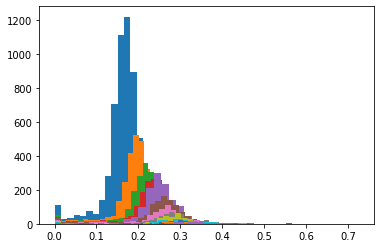

In [70]:
cuts_all = (final_df.total_hits == 1) #& (final_df.hit_ACT0 == 1) #& (final_df.hit_ACT1 == 1) #& (final_df.nohit_ACT3 == 1)

cuts = cuts_all
plt.hist(final_df[(final_df.hit_HD14 == 1) & cuts]['IntCharge'],bins=40)
plt.hist(final_df[(final_df.hit_HD13 == 1) & cuts]['IntCharge'],bins=40)
plt.hist(final_df[(final_df.hit_HD12 == 1) & cuts]['IntCharge'],bins=40)
plt.hist(final_df[(final_df.hit_HD11 == 1) & cuts]['IntCharge'],bins=40)
plt.hist(final_df[(final_df.hit_HD10 == 1) & cuts]['IntCharge'],bins=40)
plt.hist(final_df[(final_df.hit_HD9 == 1) & cuts]['IntCharge'],bins=40)
plt.hist(final_df[(final_df.hit_HD8 == 1) & cuts]['IntCharge'],bins=40)
plt.hist(final_df[(final_df.hit_HD7 == 1) & cuts]['IntCharge'],bins=40)
plt.hist(final_df[(final_df.hit_HD6 == 1) & cuts]['IntCharge'],bins=40)
plt.hist(final_df[(final_df.hit_HD5 == 1) & cuts]['IntCharge'],bins=40)
plt.hist(final_df[(final_df.hit_HD4 == 1) & cuts]['IntCharge'],bins=40)
plt.hist(final_df[(final_df.hit_HD3 == 1) & cuts]['IntCharge'],bins=40)
plt.hist(final_df[(final_df.hit_HD2 == 1) & cuts]['IntCharge'],bins=40)
plt.hist(final_df[(final_df.hit_HD1 == 1) & cuts]['IntCharge'],bins=40)
plt.hist(final_df[(final_df.hit_HD0 == 1) & cuts]['IntCharge'],bins=40)
#plt.yscale('log')

In [ ]:
valid_events

In [ ]:
# Determine ACT0 threshold: 0.1
hh = plt.hist(df_dict['ACT0L']['IntCharge'] + df_dict['ACT0R']['IntCharge'],bins=100,range=[0,0.1])

In [ ]:
# Determine ACT1 threshold: 0.02
hh = plt.hist(df_dict['ACT1L']['IntCharge'] + df_dict['ACT1R']['IntCharge'],bins=100,range=[0,0.1])

In [ ]:
hd_dfs['HD0']

In [ ]:
merged_dfs.keys()

In [ ]:
merged_dfs['PbGlass_HD0']

In [ ]:
df_dict['ACT0L'].head(10)

In [ ]:
df_dict.keys()

In [ ]:
events = uproot.open("{}".format("../ntuples/ntuple_000734.root"))
main_keys = events.keys()

In [ ]:
dataframes

## Single-peak analysis

### Runs 670 - 677: Trigger T0 and T2 Coincidence with Hodoscope OR Lead Glass - 1% Slit
#### Please note that ntuples 672 (700 MeV), 674 (900 MeV), 675 (1 GeV) and 716 (700 MeV) cannot be produced with Nick script. This is something that may need to be considered.

In [ ]:
# Convert the ROOT file to a CSV
run  = "000734"
path = "../ntuples/ntuple_"
df   = ntuple_to_pd(path + "{}.root".format(run))

In [ ]:
df.head(100)

## Peak time analysis

In [ ]:
# Create entries in dataframe for averages in peak times
df['PeakTimeACT0'] = (df['PeakTime0'] + df['PeakTime1'])/2
df['PeakTimeACT1'] = (df['PeakTime2'] + df['PeakTime3'])/2
df['PeakTimeACT3'] = (df['PeakTime4'] + df['PeakTime5'])/2
df['PeakVoltageACT3'] = (df['PeakVoltage4'] + df['PeakVoltage5'])/2
df['PeakTimeTOF0'] = (df['PeakTime8'] + df['PeakTime9'] + df['PeakTime10'] + df['PeakTime11'])/4
df['PeakTimeTOF1'] = (df['PeakTime12'] + df['PeakTime13'] + df['PeakTime14'] + df['PeakTime15'])/4

In [ ]:
rng_time = [0,200]
nbins_time = 100

fig = plt.figure(figsize=(18,7))

h_ACT0R = plt.hist(df['PeakTime0'],bins=nbins_time,range=rng_time,label="ACT0-R")
h_ACT0L = plt.hist(df['PeakTime1'],bins=nbins_time,range=rng_time,label="ACT0-L")
h_ACT1L = plt.hist(df['PeakTime2'],bins=nbins_time,range=rng_time,label="ACT1-R")
h_ACT1R = plt.hist(df['PeakTime3'],bins=nbins_time,range=rng_time,label="ACT1-L")
h_ACT3L = plt.hist(df['PeakTime4'],bins=nbins_time,range=rng_time,label="ACT3-R")
h_ACT3R = plt.hist(df['PeakTime5'],bins=nbins_time,range=rng_time,label="ACT3-L")

h_trig = plt.hist(df['PeakTime6'],bins=nbins_time,range=rng_time,label="Trigger scintillator")

h_TOF00 = plt.hist(df['PeakTime8'],bins=nbins_time,range=rng_time,label='TOF0-0')
h_TOF01 = plt.hist(df['PeakTime9'],bins=nbins_time,range=rng_time,label='TOF0-1')
h_TOF02 = plt.hist(df['PeakTime10'],bins=nbins_time,range=rng_time,label='TOF0-2')
h_TOF03 = plt.hist(df['PeakTime11'],bins=nbins_time,range=rng_time,label='TOF0-3')

h_TOF10 = plt.hist(df['PeakTime12'],bins=nbins_time,range=rng_time,label='TOF1-0')
h_TOF11 = plt.hist(df['PeakTime13'],bins=nbins_time,range=rng_time,label='TOF1-1')
h_TOF12 = plt.hist(df['PeakTime14'],bins=nbins_time,range=rng_time,label='TOF1-2')
h_TOF13 = plt.hist(df['PeakTime15'],bins=nbins_time,range=rng_time,label='TOF1-3')

plt.tick_params(axis='both', which='major', labelsize=18)
plt.ylabel("Counts/bin",fontsize=18)
plt.xlabel("Peak time (ns)",fontsize=18)

plt.legend(loc=2,fontsize=14)
plt.savefig("peak_times.png", bbox_inches='tight')

In [ ]:
rng_time = [0,200]
nbins_time = 60
alpha_time = 0.8

fig = plt.figure(figsize=(18,7))

h_ACT0 = plt.hist(df['PeakTimeACT0'],bins=nbins_time,range=rng_time,label="ACT0 avg",alpha=alpha_time)
h_ACT1 = plt.hist(df['PeakTimeACT1'],bins=nbins_time,range=rng_time,label="ACT1 avg",alpha=alpha_time)
h_ACT3 = plt.hist(df[df['PeakVoltageACT3'] > 0.5]['PeakTimeACT3'],bins=nbins_time,range=rng_time,label="ACT3 avg (V$_{peak}$ > 0.5)",alpha=alpha_time)

h_TOF0 = plt.hist(df['PeakTimeTOF0'],bins=nbins_time,range=rng_time,label='T0 avg',alpha=alpha_time)
h_TOF1 = plt.hist(df['PeakTimeTOF1'],bins=nbins_time,range=rng_time,label='T1 avg',alpha=alpha_time)

h_trig = plt.hist(df['PeakTime6'],bins=nbins_time,range=rng_time,label="T2 avg",alpha=alpha_time)

plt.tick_params(axis='both', which='major', labelsize=14)
plt.ylabel("Counts/bin",fontsize=18)
plt.xlabel("Peak time (ns)",fontsize=18)

plt.legend(loc=2,fontsize=18)
plt.savefig("peak_times_avg.png", bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))
h2_ACT3 = ax.hist2d(df['PeakTimeACT3'],df['PeakVoltageACT3'],bins=[30,30],norm=matplotlib.colors.LogNorm())
fig.colorbar(h2_ACT3[3],ax=ax)
plt.xlabel("ACT3 avg peak time (ns)",fontsize=12)
plt.ylabel("ACT3 avg peak voltage",fontsize=12)
plt.savefig("ACT3_voltage_vs_time.png", bbox_inches='tight')

## Hodoscope analysis
#### These cuts allow us to see the individual peaks in the LGCharge plot below
#### Please note these cuts are made just looking at the charge spectrum of the LG and the Hodoscope PMTs and cutting the tail, but perhaps this tail could be eliminated using cuts in the Aerogels (?)

In [ ]:
th_hd = 0.02
cut_LG  = (df['IntCharge16'] > 0.05)

cut_H0 =  df['IntCharge24'] > th_hd
cut_H1 =  df['IntCharge25'] > th_hd
cut_H2 =  df['IntCharge26'] > th_hd
cut_H3 =  df['IntCharge27'] > th_hd
cut_H4 =  df['IntCharge28'] > th_hd
cut_H5 =  df['IntCharge29'] > th_hd
cut_H6 =  df['IntCharge30'] > th_hd
cut_H7 =  df['IntCharge31'] > th_hd
cut_H8 =  df['IntCharge17'] > th_hd
cut_H9 =  df['IntCharge18'] > th_hd
cut_H10 = df['IntCharge19'] > th_hd
cut_H11 = df['IntCharge20'] > th_hd
cut_H12 = df['IntCharge21'] > th_hd
cut_H13 = df['IntCharge22'] > th_hd
cut_H14 = df['IntCharge23'] > th_hd

LG_cal = 1. #120/3.
#rng = [0, 500*3/120]
rng = [0.0, 1.5]

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6.0))

plt.hist(df[cut_H14 & cut_LG]['IntCharge16']*LG_cal, bins='auto', label="H14", alpha=0.8, range=rng)
plt.hist(df[cut_H13 & cut_LG]['IntCharge16']*LG_cal, bins='auto', label="H13", alpha=0.8, range=rng)
plt.hist(df[cut_H12 & cut_LG]['IntCharge16']*LG_cal, bins='auto', label="H12", alpha=0.8, range=rng)
plt.hist(df[cut_H11 & cut_LG]['IntCharge16']*LG_cal, bins='auto', label="H11", alpha=0.8, range=rng)
plt.hist(df[cut_H10 & cut_LG]['IntCharge16']*LG_cal, bins='auto', label="H10", alpha=0.8, range=rng)
plt.hist(df[cut_H9 & cut_LG]['IntCharge16']*LG_cal,  bins='auto', label="H9",  alpha=0.8, range=rng)
plt.hist(df[cut_H8 & cut_LG]['IntCharge16']*LG_cal,  bins='auto', label="H8",  alpha=0.8, range=rng)
plt.hist(df[cut_H7 & cut_LG]['IntCharge16']*LG_cal,  bins='auto', label="H7",  alpha=0.8, range=rng)
plt.hist(df[cut_H6 & cut_LG]['IntCharge16']*LG_cal,  bins='auto', label="H6",  alpha=0.8, range=rng)
plt.hist(df[cut_H5 & cut_LG]['IntCharge16']*LG_cal,  bins='auto', label="H5",  alpha=0.8, range=rng)
plt.hist(df[cut_H4 & cut_LG]['IntCharge16']*LG_cal,  bins='auto', label="H4",  alpha=0.8, range=rng)
plt.hist(df[cut_H3 & cut_LG]['IntCharge16']*LG_cal,  bins='auto', label="H3",  alpha=0.8, range=rng)
plt.hist(df[cut_H2 & cut_LG]['IntCharge16']*LG_cal,  bins='auto', label="H2",  alpha=0.8, range=rng)
plt.hist(df[cut_H1 & cut_LG]['IntCharge16']*LG_cal,  bins='auto', label="H1",  alpha=0.8, range=rng)
plt.hist(df[cut_H0 & cut_LG]['IntCharge16']*LG_cal,  bins='auto', label="H0",  alpha=0.8, range=rng)
  
 
plt.legend()


plt.xlabel("Lead Glass (charge)",fontsize=20)
plt.ylabel("Counts/bin",fontsize=20)
#plt.yscale('log')
plt.title("Run {}, p = +1200 MeV/c".format(run), fontsize=20);

## Fitting the Lead Glass Charge Peaks (HodosCope Peaks)
#### Just a regular gaussian fit using Scipy CurveFit

In [ ]:
from scipy.stats import norm
from scipy.optimize import curve_fit

In [ ]:
data_H14 = df[cut_H14 & cut_LG]['IntCharge16']*LG_cal
data_H13 = df[cut_H13 & cut_LG]['IntCharge16']*LG_cal
data_H12 = df[cut_H12 & cut_LG]['IntCharge16']*LG_cal
data_H11 = df[cut_H11 & cut_LG]['IntCharge16']*LG_cal
data_H10 = df[cut_H10 & cut_LG]['IntCharge16']*LG_cal
data_H9  = df[cut_H9  & cut_LG]['IntCharge16']*LG_cal
data_H8  = df[cut_H8  & cut_LG]['IntCharge16']*LG_cal
data_H7  = df[cut_H7  & cut_LG]['IntCharge16']*LG_cal
data_H6  = df[cut_H6  & cut_LG]['IntCharge16']*LG_cal
data_H5  = df[cut_H5  & cut_LG]['IntCharge16']*LG_cal
data_H4  = df[cut_H4  & cut_LG]['IntCharge16']*LG_cal
data_H3  = df[cut_H3  & cut_LG]['IntCharge16']*LG_cal
data_H2  = df[cut_H2  & cut_LG]['IntCharge16']*LG_cal
data_H1  = df[cut_H1  & cut_LG]['IntCharge16']*LG_cal
data_H0  = df[cut_H0  & cut_LG]['IntCharge16']*LG_cal

datas = [data_H0, data_H1, data_H2, data_H3, data_H4, 
         data_H5, data_H6, data_H7, data_H8, data_H9, 
         data_H10, data_H11, data_H12, data_H13, data_H14]

labels = ["H0", "H1", "H2", "H3", "H4", "H5", "H6", "H7", "H8", "H9", "H10", "H11", "H12", "H13", "H14"]

### This is not automated, you need to chage some values as you change the run, such as h, h decreasing and the text positioning since the counts decrease with the beam momentum

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6.0))
h = 1400
means = []

for i,j in zip(datas, labels):    
    data = i

    hist, bin_edges = np.histogram(data, bins='auto') 

    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    def gaussian(x, amplitude, mean, stddev):
        return amplitude * norm.pdf(x, loc=mean, scale=stddev)

    # Parámetros iniciales para el ajuste (estimaciones iniciales)
    initial_params = [1.0, 0.0, 1.0]

    # Realiza el ajuste
    popt, _ = curve_fit(gaussian, bin_centers, hist, p0=initial_params)

    # Crea una curva con los parámetros ajustados
    fit_curve = gaussian(bin_centers, *popt)

    # Grafica el histograma y la curva ajustada
    plt.hist(data, bins='auto', alpha=0.6, label=j);
    plt.plot(bin_centers, fit_curve, 'r-', alpha=0.6)
    plt.text(0.9, h, 'StdDev/Mean {}: {:.2f}'.format(j, popt[2]/popt[1]),fontsize=15)

    plt.legend()
    
    plt.xlabel('Lead Glass (charge)',fontsize=20);
    plt.ylabel('Counts/bin',fontsize=20);
    plt.title("Run {}, p = +500 MeV/c".format(run),fontsize=20);
    
    plt.xlim(0., 1.5)
    
    h -= 87
    means.append(popt[1])

    print('Valores del ajuste para {}:'.format(j))
    print('Mean: {:.2f}'.format(popt[1]))
    print('StdDev: {:.2f}'.format(popt[2]))
    print(' ')

# Try fitting just a determined range

In [ ]:
#fig, ax = plt.subplots(figsize=(12, 6.0))
#h = 500
#
#for i,j in zip(datas, labels):    
#    data = i
#
#    hist, bin_edges = np.histogram(data, bins='auto') 
#
#    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
#
#    def gaussian(x, amplitude, mean, stddev):
#        return amplitude * norm.pdf(x, loc=mean, scale=stddev)
#    
#    # Limita los datos y el eje x hasta cierto valor máximo (por ejemplo, x = 6)
#    max_x_value = 2.2
#    mask = bin_centers <= max_x_value
#    filtered_x = bin_centers[mask]
#    filtered_hist = hist[mask]
#
#
#    # Parámetros iniciales para el ajuste (estimaciones iniciales)
#    initial_params = [1.0, 0.0, 1.0]
#
#    # Realiza el ajuste
#    popt, _ = curve_fit(gaussian, filtered_x, filtered_hist, p0=initial_params)
#
#    # Crea una curva con los parámetros ajustados
#    fit_curve = gaussian(filtered_x, *popt)
#
#    # Grafica el histograma y la curva ajustada
#    plt.hist(data, bins='auto', alpha=0.6, label=j);
#    plt.plot(filtered_x, fit_curve, 'r-', alpha=0.6)
#    plt.text(2.15, h, 'StdDev {}: {:.2f}'.format(j, popt[2]),fontsize=15)
#
#    plt.legend()
#    
#    plt.xlabel('Counts/bin',fontsize=20);
#    plt.ylabel('Lead Glass (charge)',fontsize=20);
#    plt.title("Run {}, p = +800 MeV/c".format(run),fontsize=20);
#    
#    plt.xlim(0.4, 3.2)
#    
#    h -= 27
#
#    #print('Valores del ajuste:')
#    #print('Amplitude: {:.2f}'.format(popt[0]))
#    #print('Mean: {:.2f}'.format(popt[1]))
#    #print('StdDev: {:.2f}'.format(popt[2]))

# 2D Plot Expected Tagged Photon Energy vs. Lead Glass Charge

#### hit_energy values are the "expected gamma energy", computed by Josh

In [ ]:
hit_energy = [0.1595155500109545, 0.16918666630815957, 0.17050944491673403, 0.18508668641801915,
             0.1883263228952287, 0.20450156481839696, 0.21056117899451413, 0.22867222330704012,
             0.23899202319688614, 0.25950074031219433, 0.27649806820124223, 0.30005667059694635,
             0.32806001869009743, 0.3556345402074757, 0.40311754765565394]

#### IMPORTANT: Please note that you need to change the run momentum in this next cell

In [ ]:
run_momentum = 500

actual_means = means[::-1]
e_gamma_expected = [run_momentum - i*1000 for i in hit_energy[::-1]]

In [ ]:
plt.scatter(actual_means, e_gamma_expected);

plt.xlabel('Lead Glass Charge [Arbitrary Unit]');
plt.ylabel('Tagged Photon Expected Momentum [MeV/c]');

plt.title("Run {}, p = +500 MeV/c".format(run),fontsize=20);

# Aerogel Charged Particle Veto
#### Akira suggested we could use Aerogel 3 as charged particle veto ensuring only non-charged particles pass through it. Aerogels 0 & 1 can be used as veto in the opposite way. These could make us get rid of the tails that appear as beam momentum increases (see peak plots for 1200 MeV)

In [ ]:
plt.hist(df['IntCharge4'], bins=40, alpha=0.7);
plt.hist(df['IntCharge5'], bins=40, alpha=0.7);

plt.yscale('log');

plt.xlabel('Aerogel 3R & 3L Charge [Arbitrary Unit]');
plt.ylabel('Counts/bins');

In [ ]:
fig = plt.figure(figsize=(18,7))

ax1 = fig.add_subplot(121)
ax1.hist(df['IntCharge0'], bins=40, alpha=0.7, label='AG0R');
ax1.hist(df['IntCharge1'], bins=40, alpha=0.7, label='AG0L');

ax1.set_yscale('log');

ax1.set_xlabel('Aerogel 0R & 0L Charge [Arbitrary Unit]');
ax1.set_ylabel('Counts/bins');
plt.legend();

ax2 = fig.add_subplot(122)
ax2.hist(df['IntCharge2'], bins=40, alpha=0.7, label='AG1R');
ax2.hist(df['IntCharge3'], bins=40, alpha=0.7, label='AG1L');

ax2.set_yscale('log');

ax2.set_xlabel('Aerogel 1R & 1L Charge [Arbitrary Unit]');
ax2.set_ylabel('Counts/bins');
plt.legend();

#### Actual cuts for the aerogels. Many thresholds were tested and it seems like we cannot get rid of the tails using Aerogels.

In [ ]:
ag01_th = 0.0
ag3_th  = 0.1

cut_AG0R = df['IntCharge0'] > ag01_th
cut_AG0L = df['IntCharge1'] > ag01_th
cut_AG1R = df['IntCharge2'] > ag01_th
cut_AG1L = df['IntCharge3'] > ag01_th
cut_AG3R = df['IntCharge4'] < ag3_th
cut_AG3L = df['IntCharge5'] < ag3_th

cut_AG = cut_AG0R & cut_AG0L & cut_AG1R & cut_AG1L & cut_AG3R & cut_AG3L

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6.0))

plt.hist(df[cut_H14 & cut_LG & cut_AG]['IntCharge16']*LG_cal, bins='auto', label="H14", alpha=0.8, range=rng)
plt.hist(df[cut_H13 & cut_LG & cut_AG]['IntCharge16']*LG_cal, bins='auto', label="H13", alpha=0.8, range=rng)
plt.hist(df[cut_H12 & cut_LG & cut_AG]['IntCharge16']*LG_cal, bins='auto', label="H12", alpha=0.8, range=rng)
plt.hist(df[cut_H11 & cut_LG & cut_AG]['IntCharge16']*LG_cal, bins='auto', label="H11", alpha=0.8, range=rng)
plt.hist(df[cut_H10 & cut_LG & cut_AG]['IntCharge16']*LG_cal, bins='auto', label="H10", alpha=0.8, range=rng)
plt.hist(df[cut_H9  & cut_LG & cut_AG]['IntCharge16']*LG_cal,  bins='auto', label="H9",  alpha=0.8, range=rng)
plt.hist(df[cut_H8  & cut_LG & cut_AG]['IntCharge16']*LG_cal,  bins='auto', label="H8",  alpha=0.8, range=rng)
plt.hist(df[cut_H7  & cut_LG & cut_AG]['IntCharge16']*LG_cal,  bins='auto', label="H7",  alpha=0.8, range=rng)
plt.hist(df[cut_H6  & cut_LG & cut_AG]['IntCharge16']*LG_cal,  bins='auto', label="H6",  alpha=0.8, range=rng)
plt.hist(df[cut_H5  & cut_LG & cut_AG]['IntCharge16']*LG_cal,  bins='auto', label="H5",  alpha=0.8, range=rng)
plt.hist(df[cut_H4  & cut_LG & cut_AG]['IntCharge16']*LG_cal,  bins='auto', label="H4",  alpha=0.8, range=rng)
plt.hist(df[cut_H3  & cut_LG & cut_AG]['IntCharge16']*LG_cal,  bins='auto', label="H3",  alpha=0.8, range=rng)
plt.hist(df[cut_H2  & cut_LG & cut_AG]['IntCharge16']*LG_cal,  bins='auto', label="H2",  alpha=0.8, range=rng)
plt.hist(df[cut_H1  & cut_LG & cut_AG]['IntCharge16']*LG_cal,  bins='auto', label="H1",  alpha=0.8, range=rng)
plt.hist(df[cut_H0  & cut_LG & cut_AG]['IntCharge16']*LG_cal,  bins='auto', label="H0",  alpha=0.8, range=rng)

 
plt.legend()


plt.xlabel("Lead Glass (charge)",fontsize=20)
plt.ylabel("Counts/bin",fontsize=20)
#plt.yscale('log')
plt.title("Run {}, p = +1200 MeV/c".format(run), fontsize=20);